### **Runned on Kaggle**

# **Set Up⚒️**
---

In [1]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Model Hypertunning
!pip install -q keras_tuner
cls()
import keras_tuner as kt

# **Data Preparation 📥**
---

In [2]:
!pip install gdown

!rm -r dataset
!gdown "https://drive.google.com/uc?id=173k1O-FmD73M4aNu6YlCtpEILnj9OWGr" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [3]:
# Constants
IMAGE_SIZE = 300 # size of the input image
BATCH_SIZE = 32 # number of samples per gradient update
EPOCHS = 10 # number of epochs to train the model

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Specify the directory paths for the data
root_dir = "dataset/"
train_dir = f"{root_dir}train/" # path to the directory containing training data
# train_dir = f"train/" # path to the directory containing training data
valid_dir = f"{root_dir}valid/" # path to the directory containing validation data
# valid_dir = f"valid/" # path to the directory containing validation data
test_dir = f"{root_dir}test/" # path to the directory containing test data
# test_dir = f"test/" # path to the directory containing test data

# Model training
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

# **Data Loading 📥**
---

In [4]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes: 15
Classes: ['battery', 'cable', 'crt_tv', 'e_kettle', 'fridge', 'keyboard', 'laptop', 'light_bulb', 'monitor', 'mouse', 'pcb', 'phone', 'printer', 'rice_cooker', 'washing_machine']


For loading the data into memory we need a function that will iterate(loop) over all the given image paths and will load them and finally convert them into Tensorflow Dataset.

In [5]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)
    
    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)
    
    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image

In [6]:
def load_dataset(root_path: str, class_names: list, trim: int=None) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        trim (int): An integer value used to reduce the size of the data set if required.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''
    
    if trim:
        # Trim the size of the data
        n_samples = len(class_names) * trim
    else:
        # Collect total number of data samples
        n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        image_paths = list(glob(os.path.join(class_path, "*")))[:trim]
        for file_path in image_paths:
            # Load the image
            image = load_image(file_path)

            # Assign label
            label = class_names.index(class_name)

            # Store the image and the respective label
            images[n_image] = image
            labels[n_image] = label

            # Increment the number of images processed
            n_image += 1

    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]
    

    return images, labels

In [7]:
# Load the training dataset
X_train, y_train = load_dataset(root_path = train_dir, class_names = class_names)

# # Load the validation dataset
X_valid, y_valid = load_dataset(root_path = valid_dir, class_names = class_names)

# Load the testing dataset
X_test, y_test = load_dataset(root_path = test_dir, class_names = class_names)

Loading: 100%|██████████| 15/15 [00:00<00:00, 22.06it/s]


# **Data Distribution 📊**
---

In [8]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

# **Data Visualization 📈📉**
---

In [9]:
def plot_images(images: np.ndarray, labels: np.ndarray, n_rows: int=1, n_cols: int=3, class_names=class_names, figsize=(25, 16), model=None):
    """
    Plots a grid of random images and their corresponding labels, with an optional prediction from a given model.

    Args:
        images (np.ndarray): Array of images to plot.
        labels (np.ndarray): Array of labels corresponding to the images.
        n_rows (int): Number of rows in the plot grid. 
        n_cols (int): Number of columns in the plot grid. 
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (25, 8).
        model (tf.keras.Model): A Keras model object used to make predictions on the images. Default is None.

    Returns:
        None
    """
    # Randomly shuffle the images and labels
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
#         label = f"Label: {labels[i]}"
#         if class_names:
#             label += f" ({class_names[labels[i]]})"
#         title = label
        title = f"{class_names[labels[i]]}"
        if model:
            pred = model.predict(images[i][np.newaxis])
            pred_label = f"Prediction: {np.argmax(pred)}"
            pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
            if class_names:
                pred_label += f" ({class_names[np.argmax(pred)]})"
            title += f"\n{pred_label} {pred_percentage}"
        ax.set_title(title)
        ax.axis('off')
    plt.show()

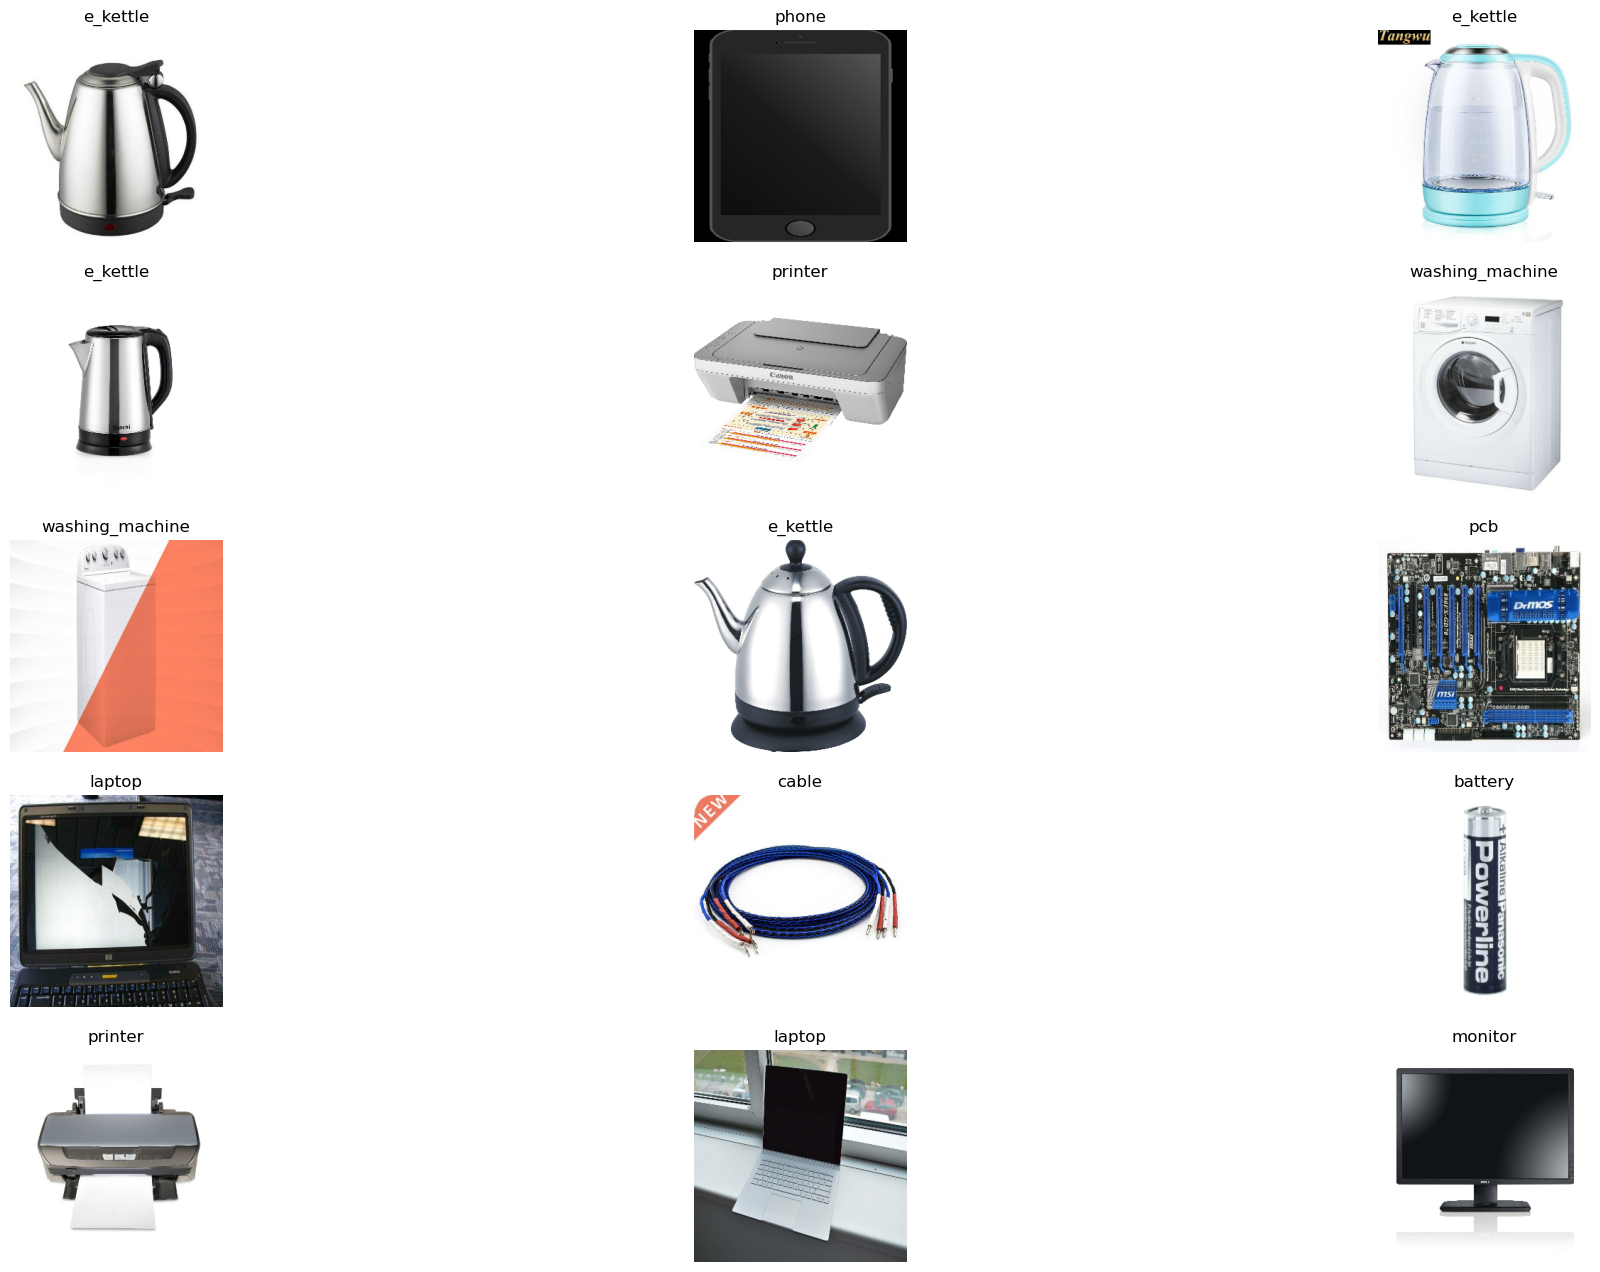

In [10]:
labels = y_train.flatten()

# Visualize Training Dataset
plot_images(images=X_train, labels=labels, n_rows=5)

# **Augment the Data 🖼**
---

In [11]:
def augment_images(images):
    # Randomly flip the images horizontally
    images = tf.image.random_flip_left_right(images)
    
    # Randomly flip the images vertically
    images = tf.image.random_flip_up_down(images)
    
    # Randomly rotate the images
    images = tf.image.rot90(images, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Randomly adjust the brightness of the images
    images = tf.image.random_brightness(images, max_delta=0.2)
    
    # Randomly adjust the contrast of the images
    images = tf.image.random_contrast(images, lower=0.8, upper=1.2)
    
    # Randomly adjust the hue of the images
    images = tf.image.random_hue(images, max_delta=0.2)
    
    # Randomly adjust the saturation of the images
    images = tf.image.random_saturation(images, lower=0.8, upper=1.2)
    
    # Make sure the pixel values are still in the range [0, 1]
    images = tf.clip_by_value(images, 0.0, 1.0)
    
    return images

In [12]:
def create_dataset(X_data, y_data, buffer_size=1024, batch_size=BATCH_SIZE, augment=False):
    # Create a tf.data.Dataset for the data
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))

    if augment:
        # Shuffle and batch the data
        dataset = dataset.shuffle(buffer_size=buffer_size).batch(batch_size=batch_size)
        
        # Apply data augmentation to the images
        dataset = dataset.map(lambda x, y: (augment_images(x), y))

        # Repeat the dataset for multiple epochs
        dataset = dataset.repeat()
        
    else:
        dataset = dataset.batch(batch_size=BATCH_SIZE)

    # Prefetch the data for better performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [13]:
# create dataset with augmented images
train_dataset = create_dataset(X_train, y_train, buffer_size=1024, batch_size=BATCH_SIZE, augment=True)
val_dataset = create_dataset(X_valid, y_valid, buffer_size=1024, batch_size=BATCH_SIZE)

In [14]:
def plot_augmented_images(X_data, BATCH_SIZE, augment_images):
    # Randomly select a batch of images from X_train
    indices = np.random.choice(len(X_train), size=BATCH_SIZE, replace=False)
    batch = X_data[indices].copy() # A batch of images as a NumPy array or a TensorFlow tensor

    images = batch

    # Apply data augmentation to the images
    augmented_images = augment_images(images)

    # Plot the original and augmented images
    n_images = len(images)
    n_cols = 2
    n_rows = n_images
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    for i in range(n_images):
        # Plot the original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Plot the augmented image
        axes[i, 1].imshow(augmented_images[i])
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis('off')
    plt.show()

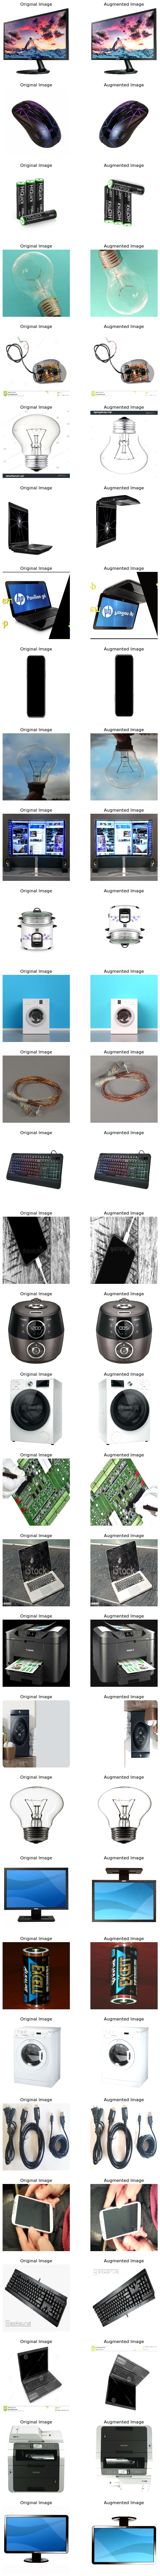

In [15]:
plot_augmented_images(X_train, BATCH_SIZE, augment_images)

In [16]:
# Delete the training and validation datasets to clean up memory
del X_train
del y_train
del X_valid
del y_valid

# **Xception Fine-Tuning 🚀**

---

In [17]:
# Xception

xception = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

xception.trainable = False

xception = Sequential([
    xception,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name='e-waste_xception_v1')

xception.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

print("\nTraining Xception Model: ")

# steps_per_epoch = len(X_train)
STEPS_PER_EPOCH = 50


history = xception.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("XceptionBaseLine.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH
)

83683744/83683744 [==============================] - 3s 0us/step

Training Xception Model: 
Epoch 1/10
50/50 [==============================] - 31s 447ms/step - loss: 1.4871 - accuracy: 0.7300 - val_loss: 0.5829 - val_accuracy: 0.9622
Epoch 2/10
50/50 [==============================] - 20s 411ms/step - loss: 0.5413 - accuracy: 0.9181 - val_loss: 0.2989 - val_accuracy: 0.9644
Epoch 3/10
50/50 [==============================] - 19s 377ms/step - loss: 0.3470 - accuracy: 0.9407 - val_loss: 0.2101 - val_accuracy: 0.9667
Epoch 4/10
50/50 [==============================] - 17s 347ms/step - loss: 0.2832 - accuracy: 0.9337 - val_loss: 0.1595 - val_accuracy: 0.9756
Epoch 5/10
50/50 [==============================] - 16s 324ms/step - loss: 0.1969 - accuracy: 0.9663 - val_loss: 0.1353 - val_accuracy: 0.9756
Epoch 6/10
50/50 [==============================] - 15s 303ms/step - loss: 0.2014 - accuracy: 0.9552 - val_loss: 0.1208 - val_accuracy: 0.9800
Epoch 7/10
50/50 [==============================] 

In [18]:
input_shape = xception.layers[0].input_shape
input_shape

(None, 300, 300, 3)

In [19]:
test_loss, test_acc = xception.evaluate(X_test, y_test)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

1/1 [==============================] - 0s 439ms/step - loss: 0.2227 - accuracy: 1.0000
Loss    : 0.2227
Accuracy: 100.0%


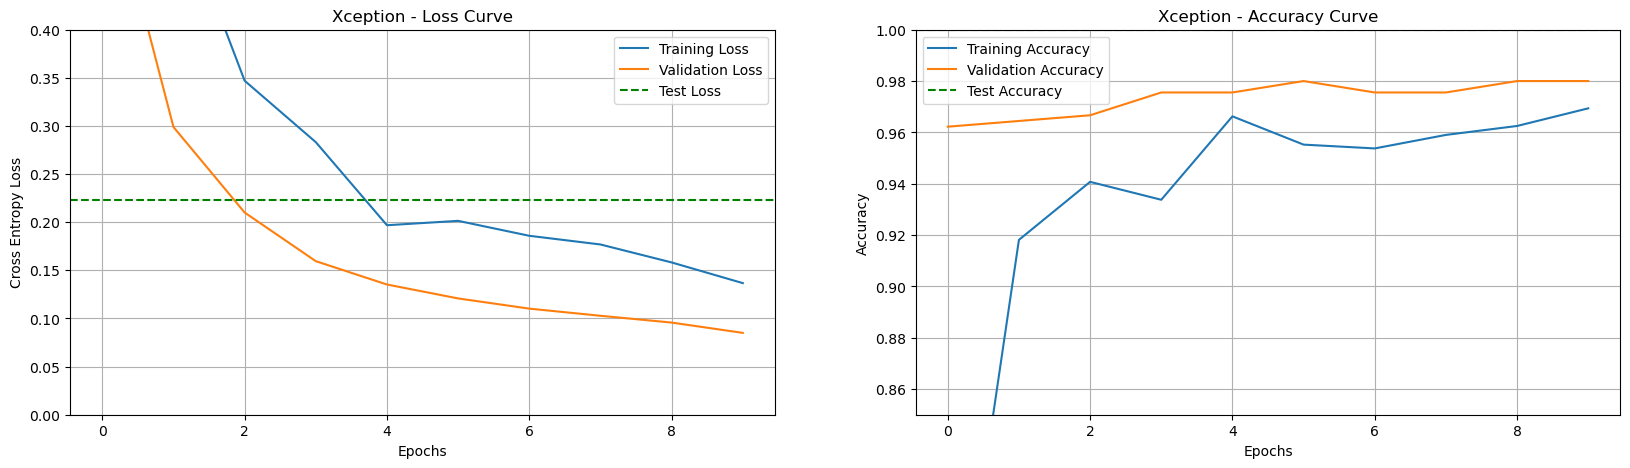

In [20]:
# Collect the history of the training run
history = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("Xception - Loss Curve")
plt.plot(history['loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("Xception - Accuracy Curve")
plt.plot(history['accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()


# **Performance Measures 💯**
---

In [21]:
# Make predictions
baseline_pred = np.argmax(xception.predict(X_test, verbose=0), axis=-1)
# best_pred = np.argmax(mobile_net_model.predict(X_test, verbose=0), axis=-1)

# Evaluate prediction : Precision
baseline_pre = precision_score(y_test, baseline_pred, average='macro', zero_division=0)
# best_pre = precision_score(y_test, best_pred, average='macro')

# Evaluate prediction : Recall
baseline_recall = recall_score(y_test, baseline_pred, average='macro', zero_division=0)
# best_recall = recall_score(y_test, best_pred, average='macro')

# Evaluate prediction : F1 Score
baseline_f1 = f1_score(y_test, baseline_pred, average='macro', zero_division=0)
# best_f1 = f1_score(y_test, best_pred, average='macro')

print("{:20}".format("Baseline Performance"))
print("{:10} : {:.5}".format("Precision", baseline_pre))
print("{:10} : {:.5}".format("Recall", baseline_recall))
print("{:10} : {:.5}".format("F1 Score", baseline_f1))

Baseline Performance
Precision  : 1.0
Recall     : 1.0
F1 Score   : 1.0


In [22]:
print(classification_report(y_test, baseline_pred, zero_division=0))

              precision    recall  f1-score   support

           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [23]:
# print(classification_report(y_test, best_pred))

# **Xception Predictions 🔮**
---

1/1 [==============================] - 0s 27ms/step


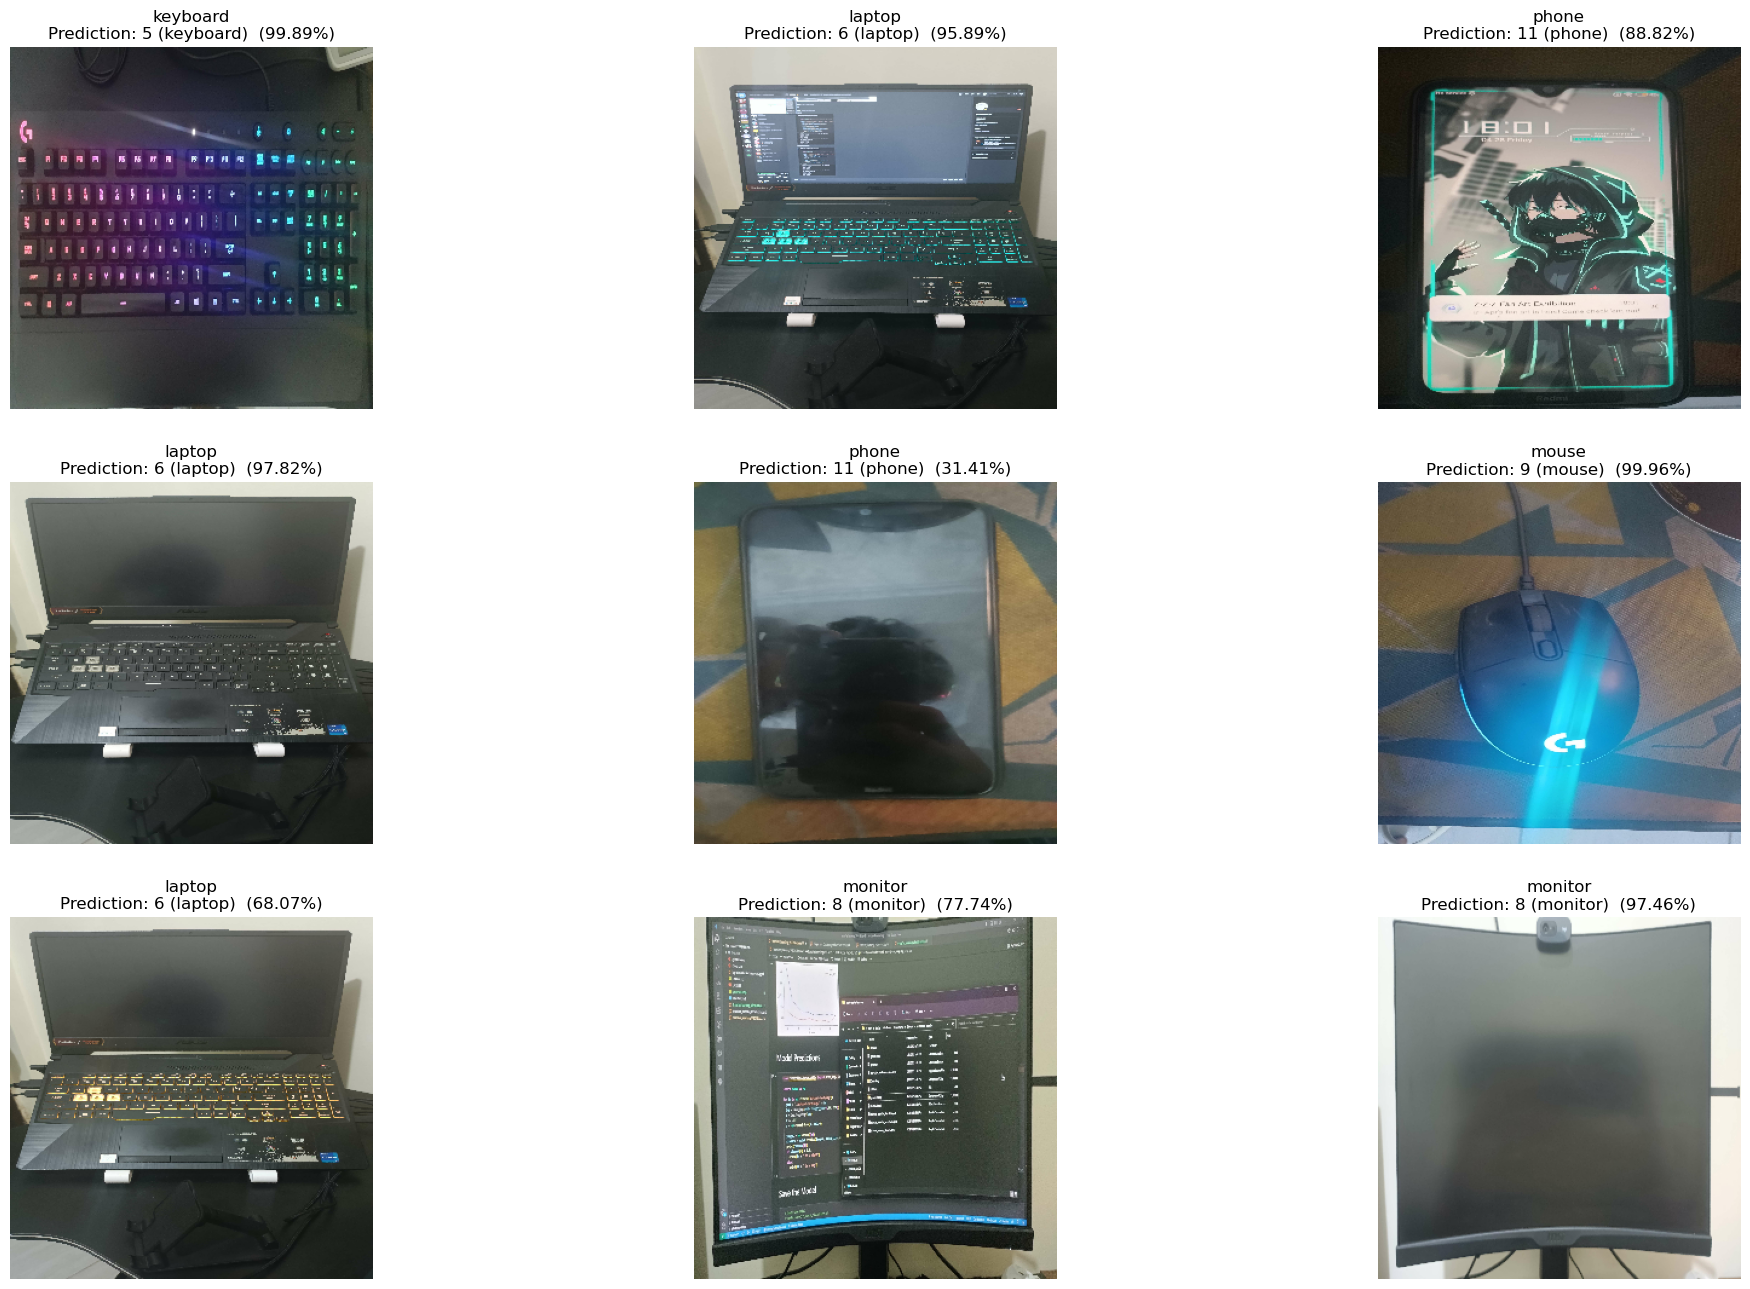

In [24]:
labels = y_test.flatten()
plot_images(images=X_test, labels=labels, model=xception, n_rows=3)

# **Xception Predictions 🔮**
---

In [25]:
xception.save('more_xception.h5')

In [26]:
model = keras.models.load_model('more_xception.h5')

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

1/1 [==============================] - 1s 1s/step - loss: 0.2227 - accuracy: 1.0000
Loss    : 0.2227
Accuracy: 100.0%
